In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
import warnings
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

In [3]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,10)
sns.set_context('poster')
sns.set_style('whitegrid')
%matplotlib inline

In [4]:
nyc_cab_df = pd.read_csv(r'C:\Users\ashwi\Desktop\CS109\Data\nyc_car_hire_data.csv',low_memory=False)

In [7]:
nyc_cab_df.head()
nyc_cab_df.sample(n=10)


,AWND,Base,Day,Dropoff_latitude,Dropoff_longitude,Ehail_fee,Extra,Fare_amount,Lpep_dropoff_datetime,MTA_tax,...,TMIN,Tip_amount,Tolls_amount,Total_amount,Trip_distance,Trip_type,Type,VendorID,lpep_pickup_datetime,Trip Length (min)
216065,8.3,B02598,30,NaN,NaN,NaN,NaN,16.704269,2014-04-30 20:16:00,NaN,...,41,NaN,NaN,NaN,2.139613,NaN,1,NaN,2014-04-30 20:07:00,9.0
1628295,4.9,NaN,25,40.802498,-73.954880,NaN,0.5,7.000000,2014-04-25 20:26:50,0.5,...,44,0.00,0.0,8.00,1.180000,1.0,0,2.0,2014-04-25 20:20:05,6.0
442688,7.6,B02682,16,NaN,NaN,NaN,NaN,21.136589,2014-04-16 08:34:00,NaN,...,31,NaN,NaN,NaN,2.610727,NaN,1,NaN,2014-04-16 08:27:00,7.0
1779486,4.3,NaN,28,40.774338,-73.871483,NaN,0.5,12.500000,2014-04-28 20:10:48,0.5,...,45,2.60,0.0,16.10,3.890000,1.0,0,2.0,2014-04-28 20:02:56,7.0
389192,6.9,B02682,8,NaN,NaN,NaN,NaN,23.342916,2014-04-08 18:09:00,NaN,...,46,NaN,NaN,NaN,4.071360,NaN,1,NaN,2014-04-08 17:56:00,13.0
455231,7.8,B02682,17,NaN,NaN,NaN,NaN,23.647275,2014-04-17 20:56:00,NaN,...,36,NaN,NaN,NaN,2.610507,NaN,1,NaN,2014-04-17 20:45:00,11.0
320303,8.3,B02617,30,NaN,NaN,NaN,NaN,18.343830,2014-04-30 04:59:00,NaN,...,41,NaN,NaN,NaN,3.479160,NaN,1,NaN,2014-04-30 04:49:00,10.0
1634327,4.9,NaN,25,40.811474,-73.855598,NaN,0.5,7.000000,2014-04-25 22:02:54,0.5,...,44,0.00,0.0,8.00,1.500000,1.0,0,1.0,2014-04-25 21:56:48,6.0
1516483,9.4,NaN,23,40.705734,-73.816528,NaN,0.0,47.000000,2014-04-23 09:05:44,0.5,...,44,0.00,0.0,47.50,15.830000,1.0,0,2.0,2014-04-23 08:31:24,34.0
1705577,5.8,NaN,27,40.679688,-73.937744,NaN,0.5,13.000000,2014-04-27 00:58:45,0.5,...,47,3.38,0.0,17.38,3.230000,1.0,0,2.0,2014-04-27 00:44:12,14.0


In [11]:
def train_test_split(df,n_sample,validation = False):
    if validation:
        nyc_cab_sample = df.sample(n_sample)
        
        nyc_cab_sample.Lpep_dropoff_datetime = nyc_cab_sample.Lpep_dropoff_datetime.apply(lambda x:pd.to_datetime(x).hour)
        nyc_cab_sample.lpep_pickup_datetime = nyc_cab_sample.lpep_pickup_datetime.apply(lambda x:pd.to_datetime(x).hour)
        
        msk = np.random.rand(len(nyc_cab_sample)) < 0.8
        non_test = nyc_cab_sample[msk]
        test = nyc_cab_sample[~msk]
        
        msk = np.random.rand(len(non_test)) < 0.7
        train = non_test[msk]
        validation = non_test[~msk]
        
        return train,validation,test
    
    else:
        nyc_cab_sample = df.sample(n_sample)
        
        nyc_cab_sample.Lpep_dropoff_datetime = nyc_cab_sample.Lpep_dropoff_datetime.apply(lambda x:pd.to_datetime(x).hour)
        nyc_cab_sample.lpep_pickup_datetime = nyc_cab_sample.lpep_pickup_datetime.apply(lambda x:pd.to_datetime(x).hour)
        
        msk = np.random.rand(len(nyc_cab_sample)) < 0.8
        train = nyc_cab_sample[msk]
        test = nyc_cab_sample[~msk]
        
        return train,test

In [70]:
train,validation,test = train_test_split(nyc_cab_df,1000,validation=True)

In [71]:
all_predictors = ['Trip Length (min)', 'Type', 'Trip_distance', 'TMAX', 'TMIN', 
                  'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Pickup_longitude', 
                  'Pickup_latitude', 'SNOW', 'SNWD', 'PRCP']

y_train = train['Fare_amount']
y_val = validation['Fare_amount']
y_test = test['Fare_amount']

In [72]:
regression_model = LinearRegression(fit_intercept=True)

In [73]:
train.describe()

,AWND,Day,Dropoff_latitude,Dropoff_longitude,Ehail_fee,Extra,Fare_amount,Lpep_dropoff_datetime,MTA_tax,PRCP,...,TMIN,Tip_amount,Tolls_amount,Total_amount,Trip_distance,Trip_type,Type,VendorID,lpep_pickup_datetime,Trip Length (min)
count,569.000000,569.000000,385.000000,385.000000,0.0,385.000000,569.000000,569.000000,385.000000,569.000000,...,569.000000,385.000000,385.000000,385.000000,569.000000,359.000000,569.000000,385.000000,569.000000,569.000000
mean,6.502988,16.193322,40.649143,-73.740334,NaN,0.389610,15.389906,13.894552,0.484416,0.339719,...,43.488576,1.101455,0.116390,15.115247,3.039473,1.027855,0.323374,1.771429,13.792619,11.131810
std,1.874018,8.839207,2.077971,3.768284,NaN,0.368197,10.205547,6.799657,0.087000,1.079845,...,6.007064,2.055487,0.806705,12.155546,3.069453,0.164787,0.468176,0.420459,6.760168,7.633451
min,2.000000,1.000000,0.000000,-74.084717,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,31.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,5.400000,9.000000,40.710629,-73.962959,NaN,0.000000,7.500000,9.000000,0.500000,0.000000,...,40.000000,0.000000,0.000000,7.500000,1.419248,1.000000,0.000000,2.000000,9.000000,6.000000
50%,6.300000,17.000000,40.757675,-73.944763,NaN,0.500000,13.397285,16.000000,0.500000,0.000000,...,43.000000,0.000000,0.000000,11.500000,2.367540,1.000000,0.000000,2.000000,16.000000,10.000000
75%,8.500000,24.000000,40.804684,-73.906425,NaN,0.500000,20.881753,19.000000,0.500000,0.050000,...,46.000000,1.800000,0.000000,18.000000,3.630000,1.000000,1.000000,2.000000,19.000000,14.000000
max,9.400000,30.000000,40.893051,0.000000,NaN,1.000000,100.000000,23.000000,0.500000,4.970000,...,59.000000,14.330000,7.500000,100.000000,39.940000,2.000000,1.000000,2.000000,23.000000,57.000000


### Variable Selection: Backwards

In [86]:
def get_aic(X_train,y_train):
    X_train = add_constant(X_train)
    model = OLS(X_train,y_train).fit()
    return model.aic

In [97]:
all_predictors = ['Trip Length (min)', 'Type', 'Trip_distance', 'TMAX', 'TMIN', 
                  'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Pickup_longitude', 
                  'Pickup_latitude', 'SNOW', 'SNWD', 'PRCP']

X_train = train[all_predictors].values
predictors = [(all_predictors,get_aic(X_train,y_train))]

for i in range(len(all_predictors),1,-1):
    aics = []
    best_k_pred = predictors[-1][0]
    
    for predictor in best_k_pred:
        
        k_minus_1 = list(set(best_k_pred) - set([predictor]))
        X_train = train[k_minus_1].values
        
        aics.append(get_aic(X_train,y_train))
    best_k_minus_1 = list(set(best_k_pred) - set(best_k_pred[np.argmin(aics)]))
    predictors.append((best_k_minus_1,np.min(aics)))

In [107]:
best_set = sorted(predictors,key=lambda x:x[1])[-1]
best_set = sorted(predictors,key=lambda x:x[1])[0]

In [114]:
X_train = train[best_set[0]].values
X_val = validation[best_set[0]].values
X_test = test[best_set[0]].values

regression_model.fit(np.vstack((X_train,X_val)),np.hstack((y_train,y_val)))
print("The best set of Variables are {} \nTest R^2 {}".format(best_set[0],regression_model.score(X_test,y_test)))

The best set of Variables are ['SNOW', 'Lpep_dropoff_datetime', 'lpep_pickup_datetime', 'Trip Length (min)', 'Trip_distance', 'Pickup_latitude', 'SNWD', 'Type', 'TMAX', 'Pickup_longitude', 'TMIN', 'PRCP'] 
Test R^2 0.8583698892483247


### Lasso Regression

In [175]:
X_train = train[all_predictors].values
X_val = validation[all_predictors].values
X_non_test = np.vstack((X_train, X_val))
X_test = test[all_predictors].values
y_non_test = np.hstack((y_train, y_val))

lasso_regression = Lasso(alpha=0.1,fit_intercept=True)
lasso_regression.fit(X_train,y_train)

print("The Lasso regression model :\n {} + {}^T".format(lasso_regression.intercept_,lasso_regression.coef_))

The Lasso regression model :
 1.581433533550575 + [ 0.19495222  7.78727222  2.29658456 -0.02033253  0.06784623  0.02060765
  0.01001068 -0.          0.          0.          0.          0.        ]^T


In [176]:
print('The Test R^2 :',lasso_regression.score(X_test,y_test))

The Test R^2 : 0.8517449507044493


### Ridge Regression

In [177]:
from sklearn.linear_model import Ridge

ridge_regression = Ridge(alpha=0.1,fit_intercept=True)
ridge_regression.fit(X_train,y_train)

print("The Ridge Regression model :/n {} + {}^T".format(ridge_regression.intercept_,ridge_regression.coef_))

The Ridge Regression model :/n -796.0412321409982 + [ 0.19849305  8.0874998   2.31419566 -0.02291925  0.07907862  0.0163809
  0.01899452 -6.14314134  8.40970519  0.          0.          0.06451696]^T


In [178]:
print("The Test R^2 :",ridge_regression.score(X_test,y_test))

The Test R^2 : 0.8484104092942854


### Variable Selection: Forwards

In [169]:
def get_aic(X_train,y_train):
    X_train = add_constant(X_train)
    model = OLS(X_train,y_train).fit()
    return model.aic

In [170]:
X_train = add_constant(train)
X_train = X_train.iloc[:,0]

In [171]:
all_predictors = ['Trip Length (min)', 'Type', 'Trip_distance', 'TMAX', 'TMIN', 
                  'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Pickup_longitude', 
                  'Pickup_latitude', 'SNOW', 'SNWD', 'PRCP']

predictors = [([],0)]

In [172]:
for k in range(1,len(all_predictors)):
    
    k_minus_1 = predictors[-1][0]
    aics = []
    new_predictors = list(set(all_predictors) - set(k_minus_1))
    
    for predictor in new_predictors:
        k_predictors = k_minus_1 + [predictor]
        
        X_train  = train[k_predictors].values
        X_val = validation[k_predictors].values
        
        if k ==1:
            X_train = X_train.reshape((-1,1))
        
        aics.append(get_aic(X_train,y_train))
    best_k = k_minus_1 + [new_predictors[np.argmin(aics)]]
    predictors.append((best_k,np.min(aics)))
    
best_predictor_set = sorted(predictors,key=lambda x:x[1])[-1]

In [173]:
best_predictor_set

(['SNOW',
  'SNWD',
  'Type',
  'PRCP',
  'Trip_distance',
  'Trip Length (min)',
  'lpep_pickup_datetime',
  'Lpep_dropoff_datetime',
  'Pickup_latitude',
  'TMIN',
  'TMAX'],
 6081.307505971352)

In [174]:
X_train = train[best_predictor_set[0]].values
X_val = validation[best_predictor_set[0]].values  
X_test = test[best_predictor_set[0]].values  

regression_model.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

print('best predictor set: {}\nvalidation R^2: {}\ntest R^2: {}'.format(best_predictor_set[0], best_predictor_set[1], regression_model.score(X_test, y_test)))

best predictor set: ['SNOW', 'SNWD', 'Type', 'PRCP', 'Trip_distance', 'Trip Length (min)', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Pickup_latitude', 'TMIN', 'TMAX']
validation R^2: 6081.307505971352
test R^2: 0.8590537922160626


### PCA

In [244]:
pca_all = PCA()
pca_all.fit(X_non_test)

print('First 4 principal components:\n', pca_all.components_[0:4])
print('Explained variance ratio:\n', pca_all.explained_variance_)

First 4 principal components:
 [[-2.88704474e-02  9.88647482e-01 -5.76778773e-03 -4.34430706e-02
  -3.00958091e-02  6.47397943e-02  7.48266746e-02 -8.34339116e-02
  -3.89992185e-02 -0.00000000e+00 -0.00000000e+00  2.53751882e-02]
 [-2.56869767e-02  9.92125681e-02 -1.84970162e-04  4.80267312e-03
  -7.39263575e-03 -6.99687499e-01 -7.06579032e-01  8.74994207e-04
   2.22055234e-02  0.00000000e+00  0.00000000e+00  1.04363733e-02]
 [ 1.59085180e-03  5.65576530e-02  8.51573494e-04  8.09148335e-01
   5.58708063e-01  8.90943183e-03 -4.19619226e-03  2.98789816e-03
  -1.17903368e-02  0.00000000e+00  0.00000000e+00 -1.72271075e-01]
 [-6.61599875e-02 -2.03556885e-02 -4.16986108e-02  7.24743051e-02
   1.97382285e-01  8.91319923e-03  3.13375363e-03 -1.24689855e-02
  -1.26492489e-02  0.00000000e+00  0.00000000e+00  9.74090700e-01]]
Explained variance ratio:
 [0.21328859 0.16806927 0.11237502 0.0408465  0.02145836 0.01467459
 0.01385983 0.00670422 0.00379506 0.00226596 0.         0.        ]


In [245]:
pca = PCA(n_components=4)
pca.fit(X_non_test)
X_non_test_pca = pca.transform(X_non_test)
X_test_pca = pca.transform(X_test)

print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [0.35706552 0.28136405 0.18812655 0.06838095]


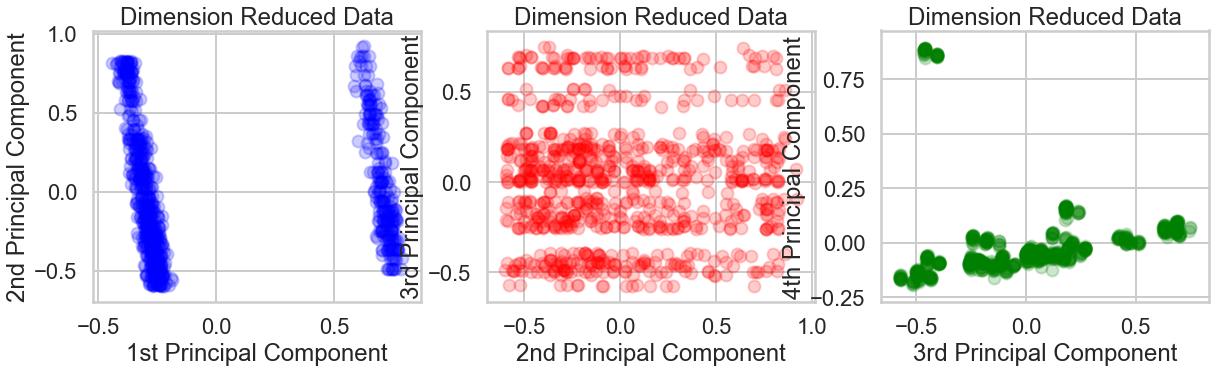

In [246]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].scatter(X_non_test_pca[:, 0], X_non_test_pca[:, 1], color='blue', alpha=0.2, label='train R^2')

ax[0].set_title('Dimension Reduced Data')
ax[0].set_xlabel('1st Principal Component')
ax[0].set_ylabel('2nd Principal Component')

ax[1].scatter(X_non_test_pca[:, 1], X_non_test_pca[:, 2], color='red', alpha=0.2, label='train R^2')

ax[1].set_title('Dimension Reduced Data')
ax[1].set_xlabel('2nd Principal Component')
ax[1].set_ylabel('3rd Principal Component')

ax[2].scatter(X_non_test_pca[:, 2], X_non_test_pca[:, 3], color='green', alpha=0.2, label='train R^2')

ax[2].set_title('Dimension Reduced Data')
ax[2].set_xlabel('3rd Principal Component')
ax[2].set_ylabel('4th Principal Component')

plt.show()

In [247]:
print('first pca component:\n', pca.components_[0])
print('\nsecond pca component:\n', pca.components_[1])
print('\nthird pca component:\n', pca.components_[2])
print('\nfourth pca component:\n', pca.components_[3])

first pca component:
 [-0.02887045  0.98864748 -0.00576779 -0.04344307 -0.03009581  0.06473979
  0.07482667 -0.08343391 -0.03899922 -0.         -0.          0.02537519]

second pca component:
 [-2.56869767e-02  9.92125681e-02 -1.84970162e-04  4.80267312e-03
 -7.39263575e-03 -6.99687499e-01 -7.06579032e-01  8.74994207e-04
  2.22055234e-02  0.00000000e+00  0.00000000e+00  1.04363733e-02]

third pca component:
 [ 0.00159085  0.05655765  0.00085157  0.80914833  0.55870806  0.00890943
 -0.00419619  0.0029879  -0.01179034  0.          0.         -0.17227107]

fourth pca component:
 [-0.06615999 -0.02035569 -0.04169861  0.07247431  0.19738228  0.0089132
  0.00313375 -0.01246899 -0.01264925  0.          0.          0.9740907 ]


In [248]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_non_test_pca, y_non_test)

print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Test R^2: 0.13466185381385998


In [249]:
pca_all.explained_variance_ratio_

array([0.35706552, 0.28136405, 0.18812655, 0.06838095, 0.03592334,
       0.02456667, 0.02320268, 0.01122351, 0.00635329, 0.00379344,
       0.        , 0.        ])

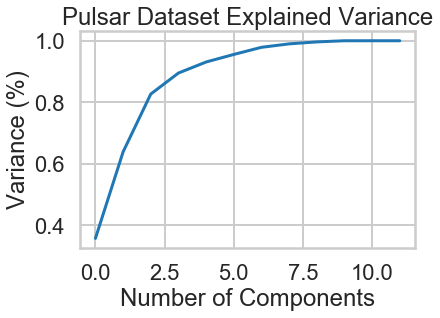

In [250]:
plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [251]:
gen_poly_terms = PolynomialFeatures(degree=6,interaction_only=False)
from sklearn.preprocessing import MinMaxScaler
min_max_scalar = MinMaxScaler()

X_non_test = min_max_scalar.fit_transform(X_non_test)
X_test = min_max_scalar.fit_transform(X_test)

X_train_full_poly = gen_poly_terms.fit_transform(X_non_test)
X_test_full_poly = gen_poly_terms.fit_transform(X_test)

print('number of total predictors', X_train_full_poly.shape[1])

number of total predictors 18564


In [252]:
pca = PCA(n_components=15)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

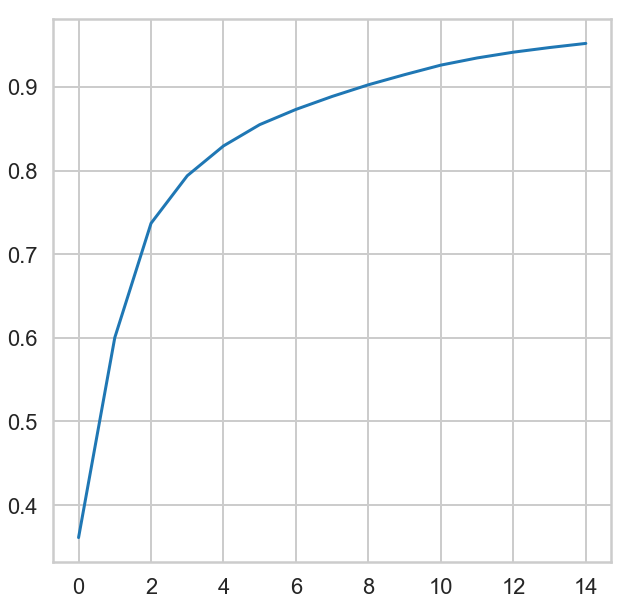

In [253]:
plt.figure(figsize=(10,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [254]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_pca, y_non_test)

print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Test R^2: -0.2797227426655826


In [255]:
pca = PCA(n_components=45)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [3.61188776e-01 2.39124898e-01 1.36637872e-01 5.68615761e-02
 3.56481124e-02 2.54684887e-02 1.82004559e-02 1.55059841e-02
 1.39334122e-02 1.21123376e-02 1.14020722e-02 8.55273729e-03
 6.89826123e-03 5.54853882e-03 4.93567892e-03 4.38809355e-03
 4.02371737e-03 3.81422592e-03 2.91860223e-03 2.41996449e-03
 2.22609224e-03 1.98346529e-03 1.81468271e-03 1.71020166e-03
 1.67925481e-03 1.53129989e-03 1.34250157e-03 1.28314623e-03
 1.13734045e-03 1.04903509e-03 9.06546602e-04 8.54490361e-04
 8.20351556e-04 7.88327568e-04 7.69222610e-04 6.93582752e-04
 6.71291015e-04 5.22831136e-04 4.62181600e-04 4.14905067e-04
 3.97156104e-04 3.74222361e-04 3.58196120e-04 3.03292167e-04
 2.87404484e-04]


In [256]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_pca, y_non_test)

print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Test R^2: -10.273077524884336


In [261]:
import sys
regression_model = LinearRegression(fit_intercept=True)
kf = KFold(n_splits=5)

x_val_scores = []

for i in range(1, 80, 5):
    out = i * 1. / 80 * 100
    sys.stdout.write("\r%d%%" % out)
    sys.stdout.flush()
    
    pca = PCA(n_components=15)
    pca.fit(X_train_full_poly)
    
    validation_R_sqs = []
    for train_index, val_index in kf.split(X_train_pca):
        X_train, X_val = X_train_full_poly[train_index], X_train_full_poly[val_index]
        y_train, y_val = y_non_test[train_index], y_non_test[val_index]

        X_train_pca = pca.transform(X_train)
        X_val_pca = pca.transform(X_val)
        
        regression_model.fit(X_train_pca, y_train)
        validation_R_sqs.append(regression_model.score(X_val_pca, y_val))
    
    x_val_scores.append(np.mean(validation_R_sqs))

sys.stdout.write("\r%d%%" % 100)

100%

In [262]:
x_val_scores

[0.49263110624534034,
 0.45428596547055805,
 0.44383537110791077,
 0.42309036061000505,
 0.47944078311571137,
 0.5623750699526913,
 0.5411317118498629,
 0.3517951922488885,
 0.27227337603993695,
 0.07400506673906788,
 0.11926157282480161,
 0.5676645604253215,
 0.3222488037344264,
 0.45245889100569403,
 -33.83544569977014,
 -67.18203872700178]

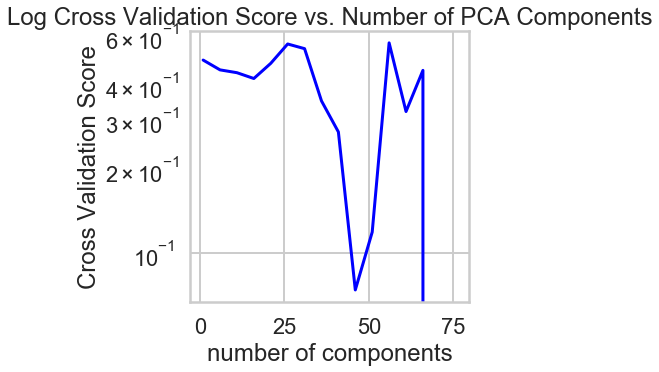

In [263]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(range(1, 80, 5), x_val_scores, color='blue')

ax.set_title('Log Cross Validation Score vs. Number of PCA Components')
ax.set_xlabel('number of components')
ax.set_ylabel('Cross Validation Score')
ax.set_yscale('log')

plt.show()

In [260]:
best_n = range(1, 80, 5)[np.argmax(x_val_scores)]

pca = PCA(n_components=best_n)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

regression_model.fit(X_train_pca, y_non_test)
test_R_sq = regression_model.score(X_test_pca, y_test)

print('best regularization param is:', best_n)
print('the test R^2 for PC regression with n = {} is: {}'.format(best_n, test_R_sq))

best regularization param is: 56
the test R^2 for PC regression with n = 56 is: -9.365695412421541
